In [1]:
!pip install ISLP
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import subplots
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
import scipy.stats as stats
from ISLP.models import ModelSpec as MS
import sklearn.model_selection as skm
import sklearn.linear_model as skl
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.stattools import durbin_watson
import scipy.stats as stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(55)

# Load the Abalone dataset
df = pd.read_csv('/kaggle/input/playground-series-s4e4/train.csv')

# One-hot encoding for 'Sex'
df = pd.get_dummies(df, columns=['Sex'], drop_first=True)

# Separate features and target
design = MS(df.columns.drop(['Rings', 'id'])).fit(df)
D = design.fit_transform(df)
D = D.drop('intercept', axis=1)
X = np.asarray(D)
#X = design.transform(df)
Y = df['Rings']

K = 5
kfold = skm.KFold(K, random_state=55, shuffle=True)
scaler = StandardScaler(with_mean=True, with_std=True)
lassoCV = skl.ElasticNetCV(n_alphas=100, l1_ratio=1, cv=kfold)
pipeCV = Pipeline(steps=[('scaler', scaler), ('lasso', lassoCV)])
pipeCV.fit(X, Y)
tuned_lasso = pipeCV.named_steps['lasso']
print("tuned_lasso.alpha_",tuned_lasso.alpha_)

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 46.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 522.0/522.0 kB 21.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.4/36.4 MB 41.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 26.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 24.3 MB/s eta 0:00:00
  

LassoCV finds the best alpha from a list of alphas using cross-validation.  
We use the best alpha to train the final Lasso model with best subset selection.

In [2]:
# Coefficients and selected features
lasso_coef = pd.Series(tuned_lasso.coef_, index=D.columns)
selected_features = lasso_coef[lasso_coef != 0]
print("Selected features:\n", selected_features)

y_pred = tuned_lasso.predict(X)
residuals = Y - y_pred

Selected features:
 Length           -0.036372
Diameter          0.587050
Height            0.797039
Whole weight      1.527853
Whole weight.1   -3.154291
Whole weight.2   -0.626571
Shell weight      2.747273
Sex_I            -0.342230
Sex_M            -0.002431
dtype: float64


Coefficients indicate feature importance. A positive coefficient means an increase in the feature tends to increase Rings, a negative coefficient means an increase in the feature tends to decrease Rings. The magnitude indicates the strength of the effect, given other features are held constant.  
Features with zero coefficients are excluded to help with best subset selection.

## Check Assumptions

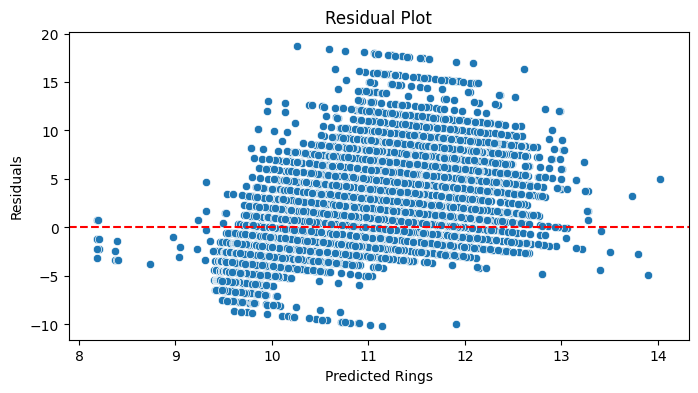

In [3]:
# Residual plot
plt.figure(figsize=(8, 4))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Rings')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

Scatter pattern around the red line rejects linearity, and funnel shape rejects constant spread (homoscedasticity).

In [4]:
dw = durbin_watson(residuals)
print(f'Durbin-Watson statistic: {dw:.2f}')

Durbin-Watson statistic: 1.82


DW ≈ 2 → no autocorrelation.  
DW < 1.5 → positive autocorrelation.  
DW > 2.5 → negative autocorrelation.

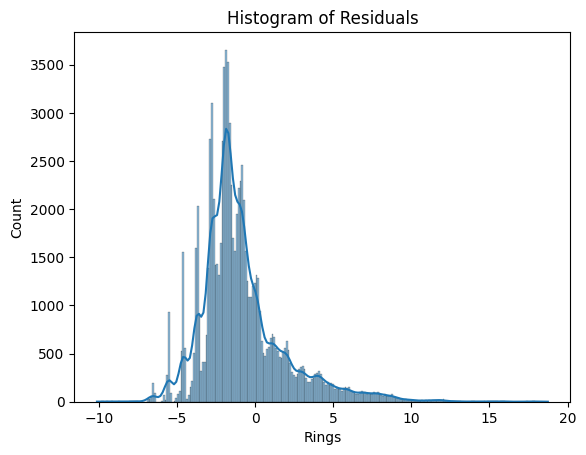

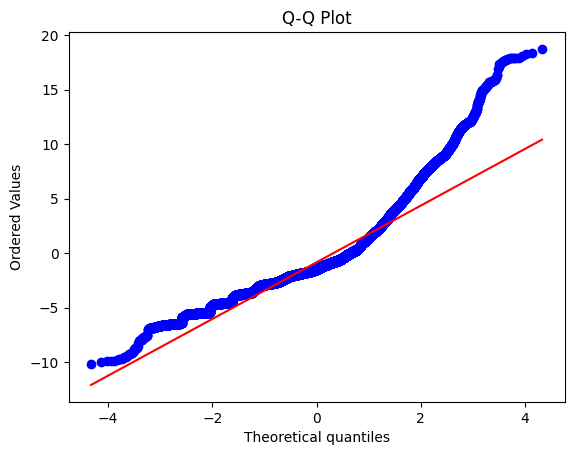

In [5]:
sns.histplot(residuals, kde=True)
plt.title("Histogram of Residuals")
plt.show()

# Q-Q plot
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("Q-Q Plot")
plt.show()

Not all points fall on 45 degree red line, the normality assumption does not hold up.

In [6]:
# Check VIFs
vif_data = pd.DataFrame()
vif_data["feature"] = D.columns
vif_data["VIF"] = [variance_inflation_factor(X, i) for i in range(X.shape[1])]
print(vif_data)

          feature         VIF
0          Length  934.989831
1        Diameter  965.624164
2          Height  103.614949
3    Whole weight  272.066683
4  Whole weight.1   80.232745
5  Whole weight.2   76.546052
6    Shell weight   72.358331
7           Sex_I    2.929687
8           Sex_M    2.122060


VIF > 5 → moderate multicollinearity.  
VIF > 10 → severe multicollinearity.

In [7]:
# --- Load test data ---
test_df = pd.read_csv("/kaggle/input/playground-series-s4e4/test.csv")
test_ids = test_df["id"]
test_df = pd.get_dummies(test_df, columns=['Sex'], drop_first=True)
design2 = MS(test_df.columns.drop('id')).fit(test_df)
D2 = design2.fit_transform(test_df)
D2 = D2.drop('intercept', axis=1)
X_test = np.asarray(D2)
# --- Predict using Model ---
preds_tuned_lasso = tuned_lasso.predict(X_test)
preds_tuned_lasso = np.maximum(0, preds_tuned_lasso)

# --- Save submission files ---
submission = pd.DataFrame({'id': test_ids, 'Rings': preds_tuned_lasso})
submission.to_csv("/kaggle/working/submission_model2.csv", index=False)
print("Submissions saved: submission_model.csv")

Submissions saved: submission_model.csv
